In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import math
from scipy import stats


def PlotSingleDistances(folder, extension, ax, log=False):
    '''Plots boxplot of distance to closest cell give ImageJ data, with or without log transformation'''
    times = GetTimes(folder, extension)
    
    file_frame = pd.concat(Generate_dfs(folder, extension, times))
    
    if log == True:
        logs = []
        for length in file_frame['Length']:
            logs.append(math.log(length))
        file_frame['Log Lengths'] = logs    
        
        b = sns.boxplot(x='Time', y='Log Lengths', data=file_frame , ax=ax)
        ax.set_ylim(-1.7,1.6)
    else:
        b = sns.boxplot(x = 'Time', y = 'Length', data=file_frame, ax=ax)
        ax.set_ylim(0,4.5)
    
    

def GetTimes(folder, extension):
    '''Takes in a folder and extension in correct format and returns list of times'''
    filenames = glob.glob("msresist/data/Distances/" + folder + "/*.csv")
    filename_prefix = "msresist/data/Distances/" + folder + "/Results_" + extension + "_"
    filename_suffix = ".csv"
    
    times = []
    for file in filenames:
        time = int(file[len(filename_prefix):-len(filename_suffix)])
        times.append(time)
    times = sorted(times)
    return times

def Generate_dfs(folder, extension, times):
    '''Generates dfs of the data at each time point with an added column for time'''
    file_list = []
    for time in times:
        file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + extension + "_" + str(time) + ".csv")
        file['Time'] = time
        file_list.append(file)
    return file_list

def Calculate_closest(file_list, n=(1,3)):
    '''Calculates distances to nearby cells and returns as dataframe ready to plot'''
    distances_by_time = pd.DataFrame()
    for idx, file in enumerate(file_list):
        distances_df = pd.DataFrame()
        points = file.loc[:,'X':'Y']
        #shortest_n_distances_lists = []
        shortest_n_distances = []
        for origin_cell in np.arange(points.shape[0]):
            distances = []
            x1,y1 = points.iloc[origin_cell, :]
            for other_cell in np.arange(points.shape[0]):
                x2,y2 = points.iloc[other_cell, :]
                distance = abs(math.sqrt((x2-x1)**2 + (y2-y1)**2))
                distances.append(distance)
            distances = sorted(distances)
            #shortest_n_distances_lists.append(distances[1:(n+1)])
            shortest_n_distances.extend(distances[n[0]:(n[1]+1)])
        distances_df['Distances'] = shortest_n_distances
        distances_df['Time'] = idx*3
        distances_by_time = distances_by_time.append(distances_df)
    return distances_by_time
                           
def PlotClosestN(folder, extension, ax, log=False, cells=(1,3)):
    '''Plots specified range of nearby cells as boxplots with or without log transformation'''
    times = GetTimes(folder, extension)
    
    file_list = Generate_dfs(folder, extension, times)
    
    plotting_frame = Calculate_closest(file_list, cells)
    
    if log == True:
        logs = []
        for length in plotting_frame['Distances']:
            logs.append(math.log(length))
        plotting_frame['Log Distances'] = logs    
        
        b = sns.boxplot(x='Time', y='Log Distances', data=plotting_frame , ax=ax)
        ax.set_ylim(-2, 2.3)
    else:
        b = sns.boxplot(x='Time', y='Distances', data=plotting_frame, ax=ax)
        ax.set_ylim(0, 8)

        

def PlotNhrsdistances(folder, mutants, treatments, replicates, ax, log=False, logmean=False, cells=(1,3)):
    '''Creates either raw/log grouped boxplot or log pointplot for distances to cells depending on log and logmean variables for range of nearby cells'''
    dfs = []
    for mutant in mutants:
        mut_frames = []
        for treatment in treatments:
            for replicate in range(1,replicates + 1):
                if replicate != 1:
                    file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + mutant + treatment + str(replicate) + ".csv")
                else:
                    file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + mutant + treatment + ".csv")
                distances = calculatedistances(file, mutant, treatment, replicate, cells)
                mut_frames.append(distances)
        mut_frame = pd.concat(mut_frames)
        dfs.append(mut_frame)
        
    to_plot = pd.concat(dfs)
    if log == True:
        logs = []
        for length in to_plot['Distances']:
            logs.append(math.log(length))
        to_plot['Log Distances'] = logs    
        if logmean == False:
            b = sns.boxplot(x='Mutant', y='Log Distances', hue='Condition', data=to_plot , ax=ax)
        else:
            b = sns.pointplot(x='Mutant', y='Log Distances', hue='Condition', data=to_plot, ci=68, join=False, dodge=.4, ax=ax)
        
    else:
        b = sns.boxplot(x='Mutant', y='Distances', hue='Condition', data=to_plot, ax=ax)
        ax.set_ylim(0,5)
        #b = sns.swarmplot(x='Mutant', y='Distances', hue='Condition', data=to_plot, dodge=True, ax=ax)
                
                
def calculatedistances(file, mutant, treatment, replicate, n=(1,3)):
    '''Calculates distances to range of other cells for a given mutant, treatment, and condition'''
    distances_df = pd.DataFrame()
    points = file.loc[:,'X':'Y']
    shortest_n_distances = []
    for origin_cell in np.arange(points.shape[0]):
        distances = []
        x1,y1 = points.iloc[origin_cell, :]
        for other_cell in np.arange(points.shape[0]):
            x2,y2 = points.iloc[other_cell, :]
            distance = abs(math.sqrt((x2-x1)**2 + (y2-y1)**2))
            distances.append(distance)
        distances = sorted(distances)
        shortest_n_distances.extend(distances[n[0]:(n[1]+1)])
    distances_df['Distances'] = shortest_n_distances
    distances_df['Mutant'] = mutant
    if replicate != 1:
        distances_df['Condition'] = treatment + str(replicate)
    else:
        distances_df['Condition'] = treatment
    return distances_df
    


def Plot_Logmean(folder, mutants, treatments, replicates, ax, vs_count=False, cells=(1,3)):
    dfs = []
    for mutant in mutants:
        mut_frames = []
        for treatment in treatments:
            for replicate in range(1,replicates + 1):
                if replicate != 1:
                    file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + mutant + treatment + str(replicate) + ".csv")
                else:
                    file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + mutant + treatment + ".csv")
                distances = calculatedistances_logmean(file, mutant, treatment, replicate, vs_count, cells)
                mut_frames.append(distances)
        mut_frame = pd.concat(mut_frames)
        dfs.append(mut_frame)
        
    to_plot = pd.concat(dfs)
    if vs_count == True:
        sns.scatterplot(x='Cells', y='Log Mean Distances', hue='Condition', style='Condition', data=to_plot, ax=ax)
    else:
        sns.pointplot(x="Mutant", y='Log Mean Distances', hue='Condition', data=to_plot, ci=68, join=False, dodge=.25, ax=ax)
    
def calculatedistances_logmean(file, mutant, treatment, replicate, vs_count, n=(1,3)):
    points = file.loc[:,'X':'Y']
    shortest_n_distances = []
    for origin_cell in np.arange(points.shape[0]):
        distances = []
        x1,y1 = points.iloc[origin_cell, :]
        for other_cell in np.arange(points.shape[0]):
            x2,y2 = points.iloc[other_cell, :]
            distance = abs(math.sqrt((x2-x1)**2 + (y2-y1)**2))
            distances.append(distance)
        distances = sorted(distances)
        shortest_n_distances.extend(distances[n[0]:(n[1]+1)])
    logs = []
    for length in shortest_n_distances:
        logs.append(math.log(length))
    log_mean = np.mean(logs)
    cell_number = points.shape[0]
    condition = treatment
    if vs_count == True:
        distances_dict = {'Log Mean Distances':[log_mean], 'Cells':[cell_number], 'Condition':[condition]}
    else:
        distances_dict = {'Log Mean Distances':[log_mean], 'Mutant':[mutant], 'Condition':[condition]}
    distances_df = pd.DataFrame(distances_dict)
    return distances_df

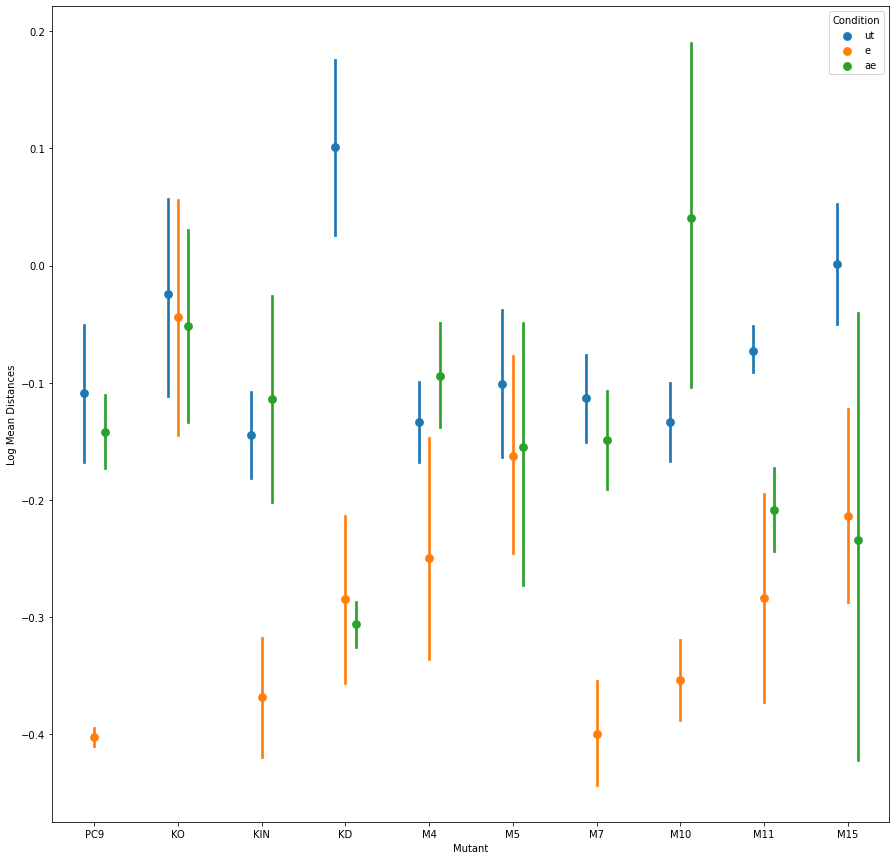

In [53]:
'''Need to: Get measurements for AF154 and include. Also, find average log mean and plot , as well as vs cell count'''

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,15))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 3
Plot_Logmean('48hrs', mutants, treatments, replicates, ax, vs_count=False, cells=(2,2))

fig.savefig("Mutants48hrs_logmean_average")

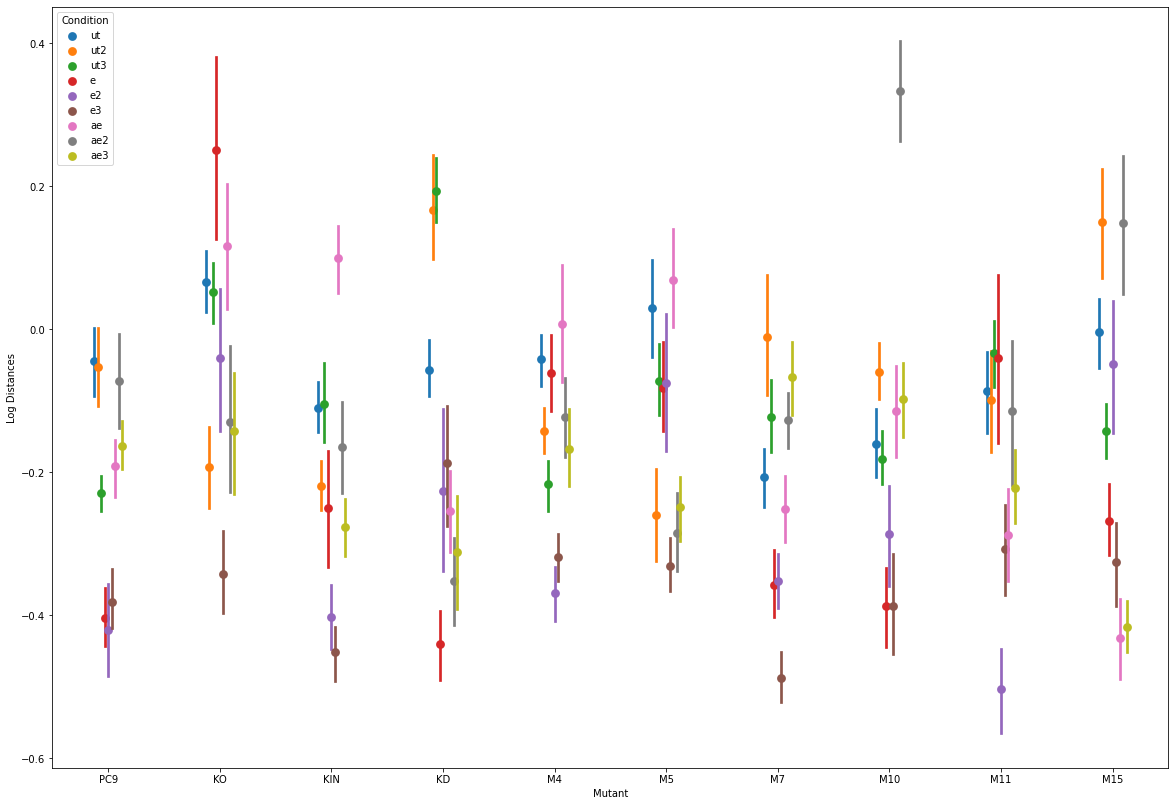

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,14))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 3
PlotNhrsdistances('48hrs', mutants, treatments, replicates, ax, log=True, logmean=True, cells=(2,2))

fig.savefig("Mutants48hrs_logmean")

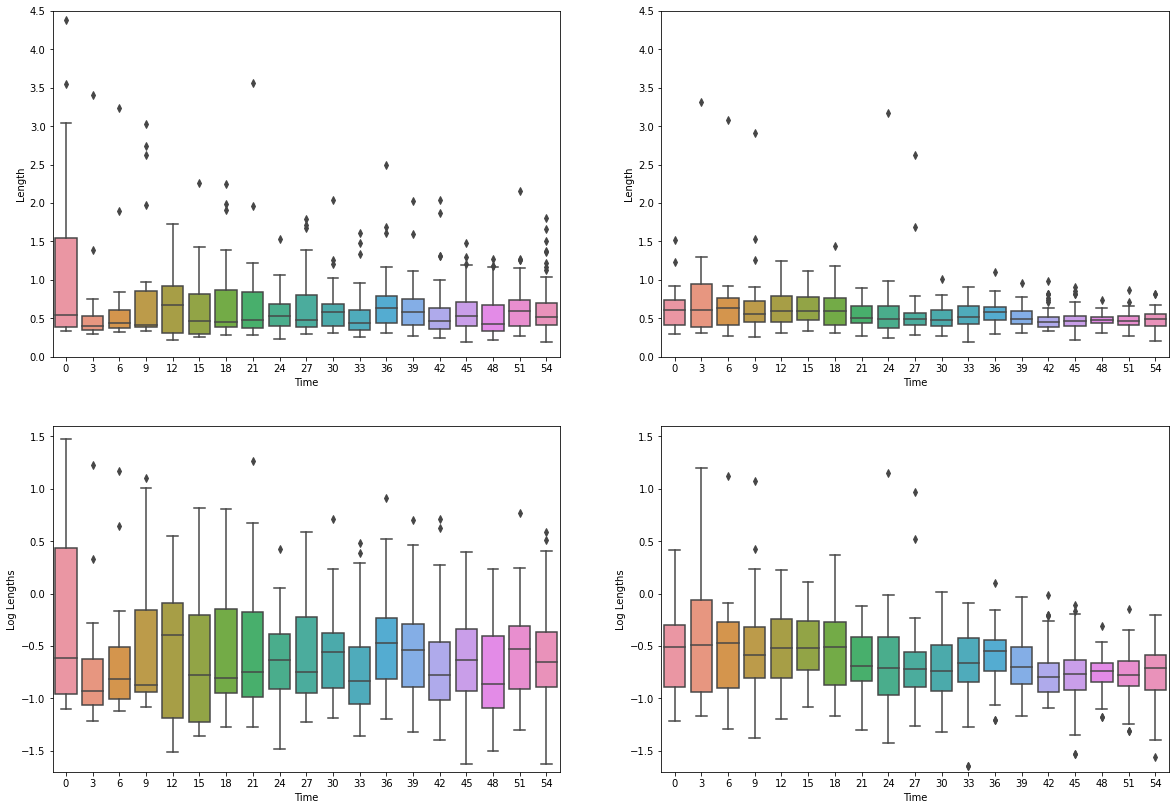

In [80]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,14))
PlotSingleDistances('PC9_UT', 'ut', ax[0,0])
PlotSingleDistances('PC9_E', 'e', ax[0,1])
PlotSingleDistances('PC9_UT', 'ut', ax[1,0], True)
PlotSingleDistances('PC9_E', 'e', ax[1,1], True)


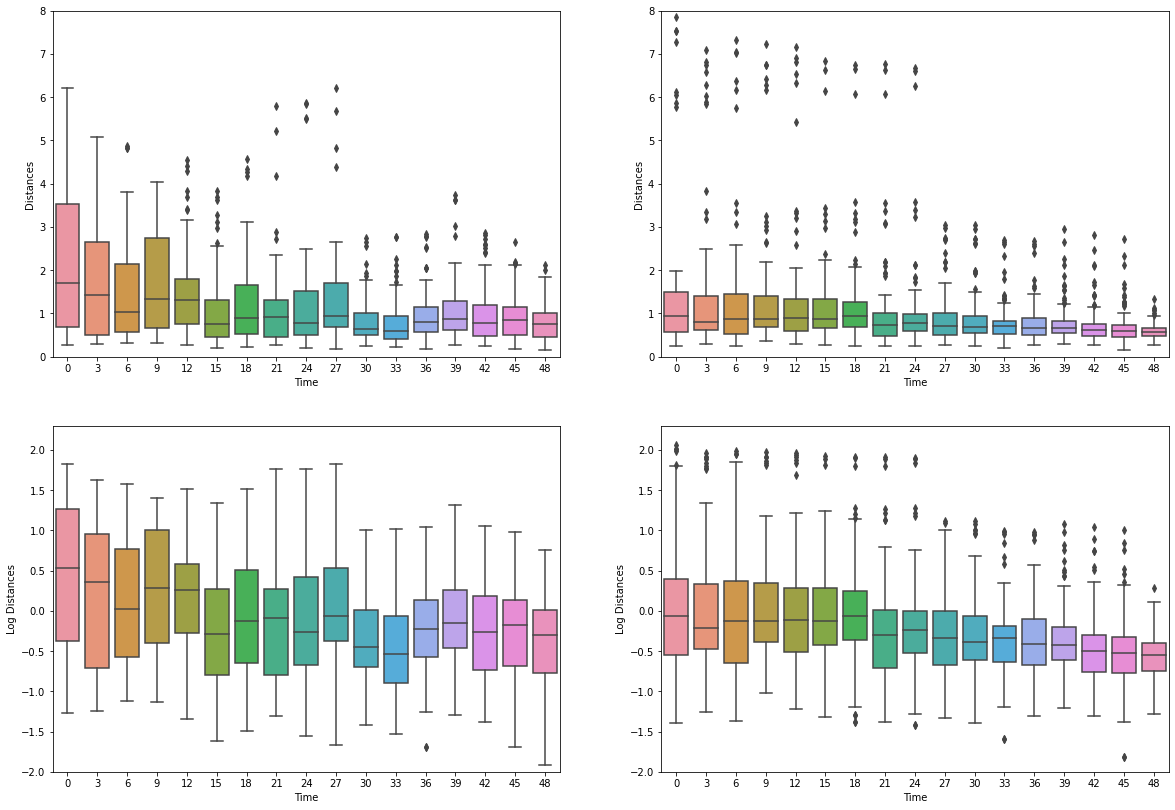

In [74]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 14))
PlotClosestN('C1', 'C1', ax[0,0])
PlotClosestN('F1', 'F1', ax[0,1])
PlotClosestN('C1', 'C1', ax[1,0], True)
PlotClosestN('F1', 'F1', ax[1,1], True)
